In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import re
from scipy import stats
import utils_last_session as utils
import seaborn as sns
import pingouin as pg
import matplotlib.cm as cm

import statsmodels.stats.power as smp
from statsmodels.stats.anova import AnovaRM


from natsort import index_natsorted

# plt.rcParams['font.family'] = 'Times New Roman'


path_figs = "./Figs/"

seq_length = 7 #Length of sequences

windowSizes = [1, 2, 3, 7]

digit_change = [2,3,4]

fingers = ['1', '2', '3', '4', '5'] #mapping of fingers to numbers

iti = 3000   #Inter trial interval
execTime = 10000 # msecs for each trial maximum
precueTime_interval = [600, 1000] # msecs for planning before movement 
hand = 2 #left or right hand

# total_sub_num = 10
sub_nums = [1, 2,3,4,5,6,7]



In [2]:
subjs_list = utils.read_dat_files_subjs_list(sub_nums)

for subj in subjs_list: ###Adding IPIs
    utils.add_IPI(subj)

subjs = pd.concat(subjs_list) ###Merging all subjs into one dataframe
subjs.reset_index(inplace=True, drop=True)

subjs_presses = utils.finger_melt(subjs).rename(columns={'isError' : 'isTrialError'})

subjs['condition'] = subjs.apply(utils.seq_condition, axis=1)
subjs_presses['condition'] = subjs_presses.apply(utils.seq_condition, axis=1)

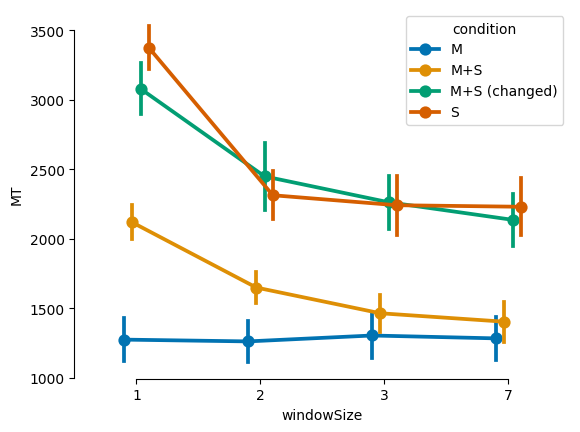

In [14]:
subjs_correct = utils.remove_error_trials(subjs)

subjs_grouped = subjs_correct.groupby(['SubNum', 'condition', 'windowSize']).agg({
    'MT': 'median'
}).reset_index()

sns.pointplot(data = subjs_grouped, x = 'windowSize', y = 'MT', hue = 'condition', errorbar='se',
              dodge = 0.2, palette='colorblind')
sns.despine(trim=True)

plt.show()

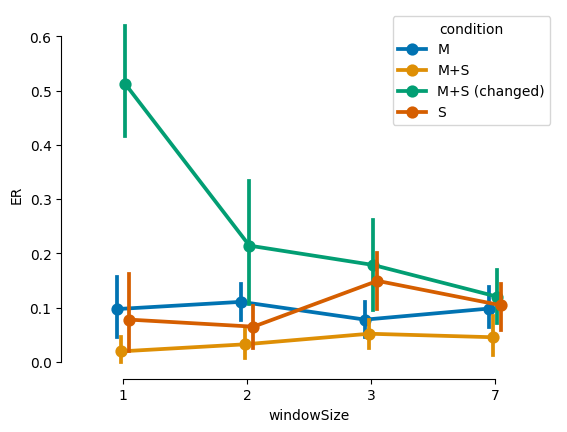

In [80]:
subjs_not_crossed = subjs[subjs["isCross"] == False].copy()
subjs_not_crossed['num_trials'] = 1
subjs_grouped = subjs_not_crossed.groupby(['SubNum', 'condition', 'windowSize']).agg({
    'isError': 'sum',
    'num_trials': 'sum'
}).reset_index()
subjs_grouped['ER'] = subjs_grouped['isError'] / subjs_grouped['num_trials']
subjs_grouped
sns.pointplot(data = subjs_grouped, x = 'windowSize', y = 'ER', hue = 'condition', dodge = True, palette='colorblind')
sns.despine(trim=True)

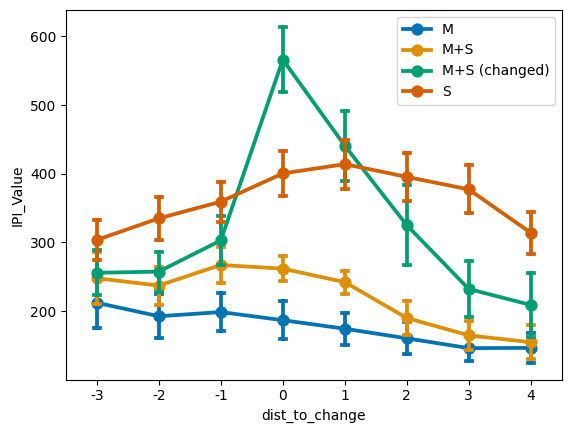

In [15]:
lookback_window = 7
presses_correct = utils.remove_error_trials_presses(subjs_presses)

#set palette colors
palette = sns.color_palette("colorblind", 4)
sns.set_palette(palette)

for condition, data in presses_correct.groupby('condition'):
    if condition == 'M+S (changed)':
        data['dist_to_change'] = data['N'] - 1 - data['digitChangePos']
        data = data[data['dist_to_change'].isin(range(-1 * lookback_window + 1, lookback_window))]

    else:
        datas = {}
        for digitpos in digit_change:
            data['dist_to_change'] = data['N'] - 1 - digitpos
            data_new = data[data['dist_to_change'].isin(range(-1 * lookback_window + 1, lookback_window))]
            datas[digitpos] = data_new
        
        data = pd.concat(list(datas.values()), ignore_index=True)
    
    data = data.groupby(['SubNum', 'dist_to_change']).agg({
        'IPI_Value': 'median'
    }).reset_index()

    sns.pointplot(data = data, x = 'dist_to_change', y = 'IPI_Value', errorbar='se', dodge = True, capsize = 0.1, 
                  label = condition)

            


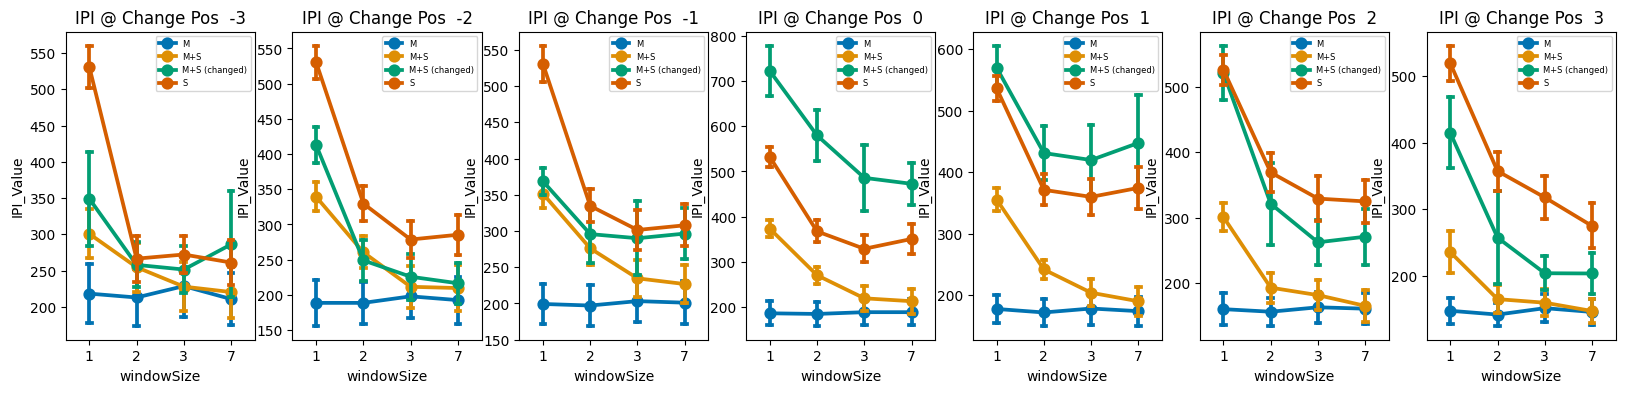

In [49]:
lookback_window = 4
presses_correct = utils.remove_error_trials_presses(subjs_presses)

#set palette colors
palette = sns.color_palette("colorblind", 4)
sns.set_palette(palette)

fig , axs = plt.subplots(ncols = lookback_window * 2 - 1, figsize = (20, 4))

for lookahead in range(-lookback_window + 1, lookback_window):

    for condition, data in presses_correct[presses_correct['N'].isin(
        pos + 1 + lookahead for pos in digit_change)].groupby('condition'):

        if condition == 'M+S (changed)':
            data = data[(data['digitChangePos'] + 1 + lookahead) == (data['N'])]


        data = data.groupby(['SubNum', 'windowSize']).agg({
            'IPI_Value': 'median'
        }).reset_index()

        ax_ind = lookahead + lookback_window - 1
        sns.pointplot(data = data, x = 'windowSize', y = 'IPI_Value', errorbar='se', dodge = True, capsize = 0.1,
                        label = condition, ax = axs[ax_ind])
        axs[ax_ind].set_title(f'IPI @ Change Pos  {lookahead}')

        #making the legend smaller
        axs[ax_ind].legend(loc = 'upper right', bbox_to_anchor = (1, 1), fontsize = 6)


            


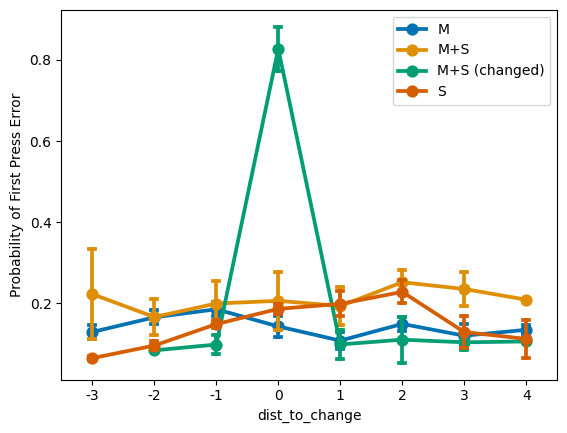

In [13]:
subjs_presses_errors = utils.remove_remaining_next_error_presses(subjs_presses).copy()
subjs_presses_errors = subjs_presses_errors[subjs_presses_errors['isPressError'] == True]

lookback_window = 7

#set palette colors
palette = sns.color_palette("colorblind", 4)
sns.set_palette(palette)

for condition, data in subjs_presses_errors.groupby('condition'):
    if condition == 'M+S (changed)':
        data['dist_to_change'] = data['N'] - 1 - data['digitChangePos']
        data = data[data['dist_to_change'].isin(range(-1 * lookback_window + 1, lookback_window))]

    else:
        datas = {}
        for digitpos in digit_change:
            data['dist_to_change'] = data['N'] - 1 - digitpos
            data_new = data[data['dist_to_change'].isin(range(-1 * lookback_window + 1, lookback_window))]
            datas[digitpos] = data_new
        
        data = pd.concat(list(datas.values()), ignore_index=True)

    
    data = data.groupby(['SubNum', 'dist_to_change']).agg({
        'isPressError': 'sum'
    }).reset_index()


    total_errors = data.groupby(['SubNum']).agg({
        'isPressError': 'sum'
    }).reset_index()
    data = data.merge(total_errors, on = 'SubNum', suffixes = ('', '_total'))
    data['isPressError'] = data['isPressError'] / data['isPressError_total']

    sns.pointplot(data = data, x = 'dist_to_change', y = 'isPressError', errorbar='se', dodge = True, capsize = 0.1, 
                  label = condition)
    plt.ylabel('Probability of First Press Error')

M
     SubNum  dist_to_change  is_first_press_error  isPressError  \
0         1              -3                 False      0.954545   
2         1              -2                 False      0.977273   
4         1              -1                 False      0.981061   
6         1               0                 False      0.996212   
8         1               1                 False      0.992424   
10        1               2                 False      0.984848   
12        1               3                 False      0.977273   
14        1               4                 False      0.965909   
16        2              -3                 False      1.000000   
17        2              -2                 False      0.982955   
19        2              -1                 False      0.988636   
21        2               0                 False      0.988636   
23        2               1                 False      1.000000   
24        2               2                 False      0.992

/var/folders/wg/16zn32014z5grhdv06dk49f00000gn/T/ipykernel_49143/2814506160.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  subjs_presses_errors = subjs_presses_copy.merge(subjs_presses_errors, on = ['SubNum', 'BN', 'TN', 'N'], how = 'left',


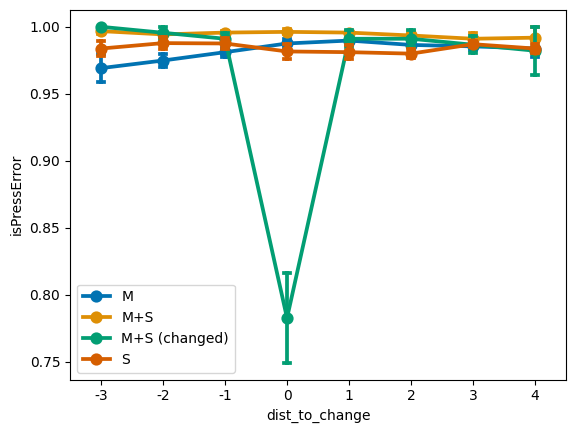

In [22]:
subjs_presses_errors = utils.remove_remaining_next_error_presses(subjs_presses).copy()
subjs_presses_errors = subjs_presses_errors[subjs_presses_errors['isPressError'] == True]
subjs_presses_errors['is_first_press_error'] = True
subjs_presses_errors = subjs_presses_errors[['SubNum', 'BN', 'TN', 'N', 'is_first_press_error']]

subjs_presses_copy = subjs_presses.copy()
subjs_presses_copy['is_first_press_error'] = False

subjs_presses_errors = subjs_presses_copy.merge(subjs_presses_errors, on = ['SubNum', 'BN', 'TN', 'N'], how = 'left', 
                                           suffixes=('', '_right')).fillna(False)
subjs_presses_errors['is_first_press_error'] = subjs_presses_errors['is_first_press_error_right']
subjs_presses_errors = subjs_presses_errors.drop(columns='is_first_press_error_right')
subjs_presses_errors

lookback_window = 7

#set palette colors
palette = sns.color_palette("colorblind", 4)
sns.set_palette(palette)

for condition, data in subjs_presses_errors.groupby('condition'):
    if condition == 'M+S (changed)':
        data['dist_to_change'] = data['N'] - 1 - data['digitChangePos']
        data = data[data['dist_to_change'].isin(range(-1 * lookback_window + 1, lookback_window))]

    else:
        datas = {}
        for digitpos in digit_change:
            data['dist_to_change'] = data['N'] - 1 - digitpos
            data_new = data[data['dist_to_change'].isin(range(-1 * lookback_window + 1, lookback_window))]
            datas[digitpos] = data_new
        
        data = pd.concat(list(datas.values()), ignore_index=True)

    
    data = data.groupby(['SubNum', 'dist_to_change', 'is_first_press_error']).agg({
        'isPressError': 'count'
    }).reset_index()


    total_errors = data.groupby(['SubNum', 'dist_to_change']).agg({
        'isPressError': 'sum'
    }).reset_index()

    data = data.merge(total_errors, on = ['SubNum', 'dist_to_change'], suffixes = ('', '_total'))
    data['isPressError'] = data['isPressError'] / data['isPressError_total']

    data = data[data['is_first_press_error'] == 0]
    print(condition)
    print(data)
    sns.pointplot(data = data, x = 'dist_to_change', y = 'isPressError', errorbar='se', dodge = True, capsize = 0.1, 
                  label = condition)
    # plt.ylabel('Probability of First Press Error')